In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import redditutils


from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline
%load_ext autoreload
%autoreload 2

Suppress Pandas' automatic conversion of utc column to scientific notation:

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df = pd.read_csv('showerthoughts.csv')

In [5]:
len(df[df.score > 1]) / len(df)

0.392702

39% of submissions get more than one upvote. This makes "greater than one upvote" a good candidate for our criteria for a good post.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
author          1000000 non-null object
title           1000000 non-null object
subreddit       1000000 non-null object
score           1000000 non-null int64
num_comments    1000000 non-null int64
retrieved_on    1000000 non-null int64
id              1000000 non-null object
created_utc     1000000 non-null int64
selftext        591622 non-null object
dtypes: int64(4), object(5)
memory usage: 68.7+ MB


In [7]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

In [9]:
pd.set_option('display.max_colwidth', 999)

In [10]:
df[df.score > 15000].sort_values(by='score', ascending=False)[['title', 'score']]

,title,score
991644,"College students don't want to go to graduation ceremonies, but they go to please their relatives, while relatives don't want to go but go to support the students; we should all just be honest and skip that ceremony and go out for pizza.",119052
962154,"The sentence ""Don't objectify women"" has ""women"" as the object of the sentence.",117934
998335,Being 35 and not wanting to work in the field for which you've prepared is like being half way through an RPG and realizing you've built out your skill tree all wrong and you can't respec and you can't make a new character and there will never be another video game again,117154
995932,"A guy named ""Weird Al"" has had a 40+ year long career with no allegations of sexual impropriety.",115008
999607,"The olympics is the only time when you hear ""Great execution by North Korea"" and it seems okay.",113782
988823,"This ""Spring Forward"" thing would be a lot more popular if we moved the clocks ahead at 2PM on Monday.",109257
999627,"If we rebranded ""Sunburns"" as ""Radiation burns"" people would take the dangers more seriously.",103607
997418,If you place a humidifier and a dehumidifier in the same room you can wirelessly transmit water,98755
998236,"Tinder is the opposite of porn site advertisements. There actually are a ton of hot singles in my area, but none of them are interested in me.",97392
999745,"I'm not a millennial, but if I was I'd be damn tired of another article every other day with a new theory about who millennials are and what they want.",95105


In [11]:
df.sample(50)

,author,title,subreddit,score,num_comments,retrieved_on,id,created_utc,selftext
66080,madbaddangerous2know,Why do we call meatloaf meatloaf but we don't call a loaf of bread breadloaf?,Showerthoughts,1,0,1484259507,5e559j,2016-11-21 17:10:22,[removed]
815596,trappedcouchfarts,It's amazing men stand to pee given the risk of sideways spray,Showerthoughts,0,4,1494638490,67rpt6,2017-04-26 22:55:14,NaN
127253,hungdaddy101,Mitch Hedbergs stand up jokes are essentially shower thoughts,Showerthoughts,1,0,1459198308,46j7b5,2016-02-19 05:49:21,[removed]
816020,charlienesh,"Anything grape flavored like soda or gum, actually tastes nothing like a real grape.",Showerthoughts,1,4,1455040380,437s4a,2016-01-29 07:10:21,NaN
613475,catentertainer,Annie Wilkes from Misery is the patron saint of don’t meet your idols,Showerthoughts,5,1,1540130796,9gacs3,2018-09-16 12:58:26,NaN
480520,[deleted],Pandora should have an option where only live concert versions of the songs would play,Showerthoughts,1,1,1463456619,49l6r5,2016-03-08 23:22:23,[deleted]
963160,adeadart,"If Jesus was crucified this year instead of 0 BC, we would have all kinds of incredible footage because everyone would have a smartphone.",Showerthoughts,4,13,1463438184,48ifc8,2016-03-01 20:26:43,NaN
297210,[deleted],What if the crusades were a masterful manipulation to drive away those that could challenge the kings?,Showerthoughts,1,0,1529686132,8hezsl,2018-05-06 12:51:28,[removed]
867636,Getrektm8ter,"In modern time, if you make a joke many people will take if dead seriously",Showerthoughts,3,5,1540064046,9cbm7a,2018-09-02 12:12:24,[removed]
970675,pirate_door91,Pop-up ads are the Zubats of the internet.,Showerthoughts,458,15,1484421950,5jbrak,2016-12-20 06:22:35,NaN


## Visualizations

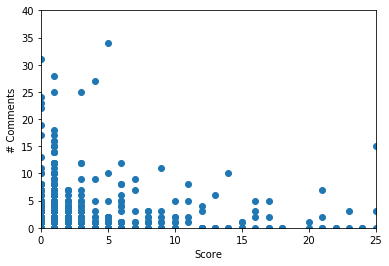

In [12]:
plt.scatter(df.score.sample(1000), df.num_comments.sample(1000))
plt.xlabel('Score')
plt.ylabel('# Comments')
plt.xlim([0, 25])
plt.ylim([0, 40]);

Poisson distribution when logged?

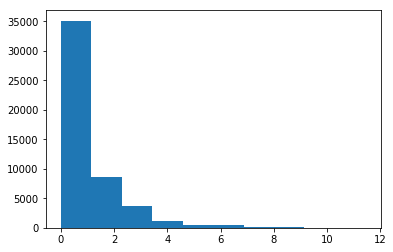

In [13]:
plt.hist(np.log1p(df.score.sample(50000)));

## Clean the data

In [14]:
df_nlp = df.copy()

### Tokenize by word

In [18]:
def strip_punc(s):
    return ''.join(c for c in s if c not in punctuation)

In [15]:
df_nlp['title'] = df_nlp['title'].apply(lambda x: word_tokenize(x))

In [16]:
df_nlp['title'] = df_nlp['title'].apply(lambda x: list(map(redditutils.lower_string, x)))

In [19]:
df_nlp['title'] = df_nlp['title'].apply(lambda x: list(map(strip_punc, x)))

In [20]:
df_backup = df_nlp.copy()

In [22]:
df_nlp['title'] = df_nlp['title'].apply(lambda x: list(map(redditutils.strip_nums, x)))

In [23]:
stop_words = set(stopwords.words('english'))

In [25]:
def strip_stops(s):
    if s in stop_words:
        return ''
    else:
        return s

In [27]:
df_nlp['title'] = df_nlp['title'].apply(lambda x: list(map(strip_stops, x)))

In [ ]:
df_nlp.to_csv('tokenized.csv')